In [1]:
using JuMP
using Ipopt
using COPSBenchmark
import Plots

In [5]:
function rocket_model(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh],          (start=1.0)
        0.0 <= v[i=0:nh],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh],  D_c*v[i]^2*exp(-h_c*(h[i] - h_0))/h_0
        g[i=0:nh],  g_0 * (h_0 / h[i])^2
        dh[i=0:nh], v[i]
        dv[i=0:nh], (T[i] - D[i] - m[i]*g[i]) / m[i]
        dm[i=0:nh], -T[i]/c
    end)

    @objective(model, Max, h[nh])

    # Dynamics
    @constraints(model, begin
        con_dh[i=1:nh], h[i] == h[i-1] + 0.5 * step * (dh[i] + dh[i-1])
        con_dv[i=1:nh], v[i] == v[i-1] + 0.5 * step * (dv[i] + dv[i-1])
        con_dm[i=1:nh], m[i] == m[i-1] + 0.5 * step * (dm[i] + dm[i-1])
    end)
    # Boundary constraints
    @constraints(model, begin
        h_ic, h[0] == h_0
        v_ic, v[0] == v_0
        m_ic, m[0] == m_0
        m_fc, m[nh] == m_f
    end)

    return model
end

rocket_model (generic function with 1 method)

In [6]:
nhs = [100,500,1000,5000,10000]
function Generate_thrust(nhs=nhs)
    Thrusts = [[] for i in range(1,length(nhs))]
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = COPSBenchmark.rocket_model(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value);
        Thrusts[i] = T_Array
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust (generic function with 2 methods)

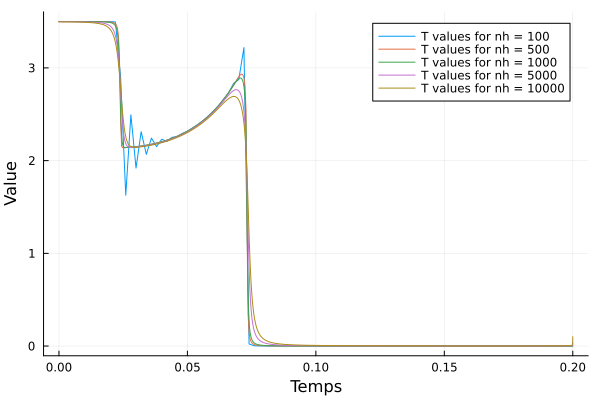


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality c

5-element Vector{Vector{Any}}:
 [3.4999429139953793, 3.499969488705402, 3.499962472923995, 3.4999528903931467, 3.4999393482761767, 3.4999193687420145, 3.499888194048052, 3.4998357275610172, 3.4997373855410565, 3.4995199261164562  …  1.9481707264974463e-5, 1.993760792222622e-5, 2.0546631570015158e-5, 2.1367077618526654e-5, 2.2497118196752243e-5, 2.4117938032242982e-5, 2.661284676870323e-5, 3.100073165591448e-5, 4.1759834036958534e-5, 0.00010670986098264428]
 [3.4997410859958387, 3.499868797497658, 3.499863781616074, 3.4998584965347845, 3.499852916501899, 3.4998470178664234, 3.499840775656195, 3.4998341628030367, 3.499827149709235, 3.499819703869399  …  0.0001617824404187642, 0.00016958489517064263, 0.00017906208684261962, 0.000190890208360447, 0.0002062027239448514, 0.0002270862287305967, 0.0002579525055214044, 0.0003105543399423355, 0.00043713195247268124, 0.0011596949616867022]
 [3.4994885322004876, 3.499742501213245, 3.499737634092226, 3.4997326691909807, 3.4997275818421394, 3.499722

In [7]:
Thrusts=Generate_thrust()

In [24]:
function rocket_model_collo(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh],          (start=1.0)
        0.0 <= v[i=0:nh],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh],  D_c*v[i]^2*exp(-h_c*(h[i] - h_0))/h_0
        g[i=0:nh],  g_0 * (h_0 / h[i])^2
        dh[i=0:nh], v[i]
        dv[i=0:nh], (T[i] - D[i] - m[i]*g[i]) / m[i]
        dm[i=0:nh], -T[i]/c
    end)

    @objective(model, Max, h[nh])

    # Dynamics à modifier
    @constraints(model, begin
        con_dh[i=1:nh-1], h[i] == h[i-1] + (1/12) * step * ( 8 * (dh[i] + dh[i-1]) - (dh[i+1] + dh[i-1]) )
        con_dv[i=1:nh-1], v[i] == v[i-1] + (1/12) * step * ( 8 * (dv[i] + dv[i-1]) - (dv[i+1] + dv[i-1]) )
        con_dm[i=1:nh-1], m[i] == m[i-1] + (1/12) * step * ( 8 * (dm[i] + dm[i-1]) - (dm[i+1] + dm[i-1]) )
    end)
    # Boundary constraints
    @constraints(model, begin
        h_ic, h[0] == h_0
        v_ic, v[0] == v_0
        m_ic, m[0] == m_0
        m_fc, m[nh] == m_f
    end)

    return model
end

nhs = [100,500,1000,5000,10000]
function Generate_thrust_collo(nhs=nhs)
    Thrusts = [[] for i in range(1,length(nhs))]
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model_collo(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value);
        Thrusts[i] = T_Array
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust_collo (generic function with 2 methods)

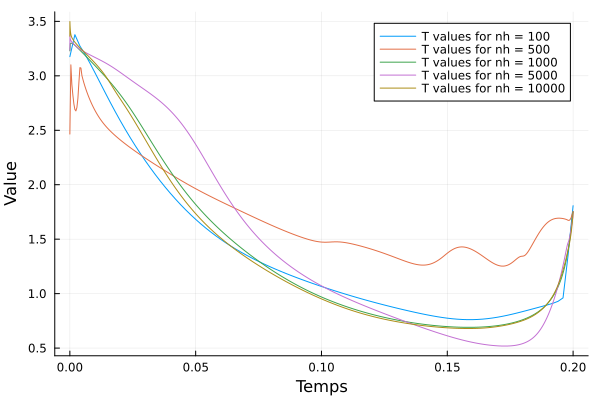

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2875
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9603

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      301
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 4.08e-02 2.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

5-element Vector{Vector{Any}}:
 [3.176122761752783, 3.3778176868679197, 3.273427064320967, 3.1992963304479014, 3.1154134315638133, 3.0274979840380745, 2.93755568620099, 2.8474548886325164, 2.7587161098417945, 2.6723819679189975  …  0.8476710193169013, 0.860018393616045, 0.8724465891587435, 0.8849571598337923, 0.8977718804342688, 0.9116528517312945, 0.9290967571347143, 0.9608504965430844, 1.3513901171520881, 1.807385251253436]
 [2.465107675592353, 3.100842168775733, 2.9201109704639667, 2.821927042788251, 2.741436864624343, 2.6905915580939417, 2.6777745797803827, 2.709095329159652, 2.7934912615364316, 2.9407084771470737  …  1.6873106805381526, 1.6849332979260458, 1.6820225404107714, 1.67844177753343, 1.6734853357896393, 1.6720931162927553, 1.6795279393498717, 1.696046586210577, 1.729390739338106, 1.7532766705660525]
 [3.229296136918837, 3.29803708574944, 3.2967039655295425, 3.2991496615549143, 3.2994832445570874, 3.2980677272281014, 3.295575802120964, 3.292414288775875, 3.288801521947723

In [25]:
Generate_thrust_collo()